# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, y_train_orig = train['features'], train['labels']
X_test_orig, y_test_orig = test['features'], test['labels']
print('training and testing data loaded')

training and testing data loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

n_train = len(X_train_orig)
n_test = len(X_test_orig)
image_shape = X_train_orig[0].shape
n_classes = len(set(y_train_orig))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

display training data classes


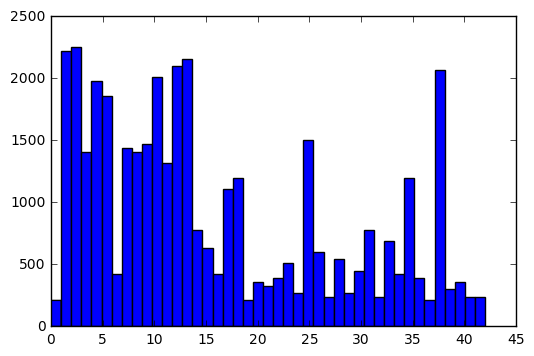

display image no 3825, label: 2


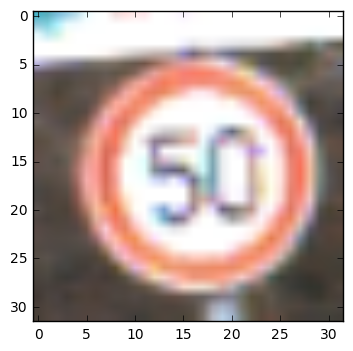

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

def show_labels_histogram(labels):
    bins = len(set(labels))
    plt.hist(labels, bins=bins)
    plt.show()
    
print('display training data classes')
show_labels_histogram(y_train_orig)


def display_image(img_data):
    plt.imshow(img_data)
    plt.show()
    
def display_sample(images, labels, count=1):
    for i in range(count):
        rand_idx = random.randint(0, len(labels)-1)
        sample_img = images[rand_idx]
        sample_label = labels[rand_idx]
        print('display image no %d, label: %d' % (rand_idx, sample_label))
        display_image(sample_img)

display_sample(X_train_orig, y_train_orig)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
# Rotate image function
import cv2
import math
PI = math.pi
prime = 997


rotate_rand_state = 0
def _abs_rad(angle):
    return abs(angle / 180. * PI)

def rotate_image(img):
    """ Randomly rotate image for angles [-10., 10.] 
        and scale to fit 32*32 image
    """
    global rotate_rand_state
    # TODO(Olala): unnecessary to copy?
    img = np.copy(img)
    rotate_rand_state = rotate_rand_state + 1
    angles = [-10., -5., 5., 10.]
    angle = angles[(rotate_rand_state*prime)%len(angles)]
    _w, _h, _d = img.shape
    rad = _abs_rad(angle)
    scale = math.sin(PI*0.75-rad) / math.sin(PI/4.)
    M = cv2.getRotationMatrix2D((_w/2, _h/2), angle,scale)
    dst = cv2.warpAffine(img, M, (_w,_h))
    
    return dst

augmented data found, unpickle file ...
display image no 18177, label: 36


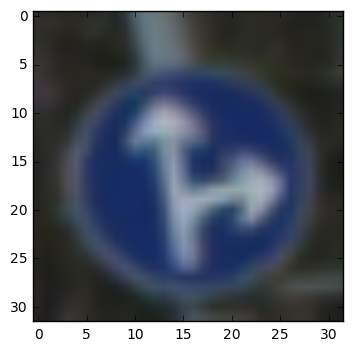

In [5]:
# Increas training data for classes less than 500 samples

import numpy as np
from os.path import isfile
from collections import Counter

augment_times = 4


def augment_data(X, y):
    counter = Counter(y)
    new_X = []
    new_y = []
    for i in range(len(y)):
        label = y[i]
        if counter[label] < 500:
            for j in range(augment_times):
                new_image = rotate_image(X[i])
                new_X.append(new_image)
                new_y.append(label)
    new_X = np.array(new_X)
    new_y = np.array(new_y)
                
    return np.array(new_X), np.array(new_y)

training_file_aug = 'train_aug.p'
testing_file_aug = 'test_aug.p'

X_aug, y_aug = None, None
if isfile(training_file_aug) and isfile(testing_file_aug):
    # exteded training and testing set found
    print('augmented data found, unpickle file ...')
    with open(training_file_aug, mode='rb') as f:
        X_aug = pickle.load(f)
    with open(testing_file_aug, mode='rb') as f:
        y_aug = pickle.load(f)
else:
    print('no augmented data found, generate new images ...')
    X_aug, y_aug = augment_data(X_train_orig, y_train_orig)
    with open(training_file_aug, mode='wb') as f:
        pickle.dump(X_aug, f)
    with open(testing_file_aug, mode='wb') as f:
        pickle.dump(y_aug, f)


if len(X_aug) > 0:    
    X_train_new = np.concatenate((X_train_orig, X_aug))
    y_train_new = np.concatenate((y_train_orig, y_aug))
    display_sample(X_aug, y_aug)
    del X_train_orig
    del X_aug
    del y_train_orig
    del y_aug
else:
    X_train_new = X_train_orig
    y_train_new = y_train_orig


Agemented data distribution


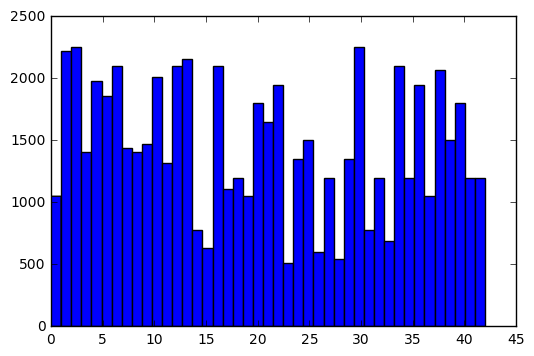

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# normalize image data from ~1.0 to 1.0
X_train = (X_train_new - 128.)/128.
y_train = y_train_new
X_test = (X_test_orig - 128.)/128.
y_test = y_test_orig

print('Agemented data distribution')
show_labels_histogram(y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Some steps are applied on the training data:
    1. Normalize image from 0~255 into -1.0 ~ 1.0
    2. Augment training data classes that has less than 250 samples, by rotating the image a randomly (-10~10 degree) and scale the image to fit into the 32x32 square image.
    
    I normalized all features space into range -1.0 ~ 1.0 to increase the speed of opimizer and avoid training biased by any features, I augmented the data sets that have less than 250 samples to avoid my network biased by probability of the occurance of data.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

def MyNet(x, keep_prob):
    mu = 0
    sigma = 0.1
    
    # layer 1: convolutional. 32*32*3 -> 28*28*6
    conv1_width = 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, conv1_width), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_width))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Down sampling: max pooling. 28*28*6 -> 14*14*6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 2: convolutional. 14*14*6 -> 10*10*16
    conv2_width = 16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_width, conv2_width), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_width))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Down sampling: 10*10*16 -> 5*5*16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten data: 5*5*16 -> 400
    fc0 = tf.contrib.layers.flatten(conv2)
    conv3_width = 5*5*conv2_width
    
    # Layer 3: fullay connected. 400 -> 120
    fc1_width = 120
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(conv3_width, fc1_width), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_width))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # dropout with keep prob
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    # Layer 4: fully connected. 120 -> 84
    fc2_width = 84
    fc2_W = tf.Variable(tf.truncated_normal(shape=(fc1_width, fc2_width), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(fc2_width))
    fc2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: fully connected. 120 -> 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(fc2_width, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [8]:
# Training pipeline
EPOCHS = 200
# BATCH_SIZE = 128
BATCH_SIZE = 256
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='data')
y = tf.placeholder(tf.int32, (None), name='label')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
one_hot_y = tf.one_hot(y, n_classes)

logits = MyNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y,
                                keep_prob: dropout,
                            })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Results

| EPOCH | rate  | augment times |   | valicate Accuracy  |
|-------|-------|------|---|----------|
| 50    | 0.001 | 0    |   | 0.992  |
| 50    | 0.001 | 1    |   | 0.9907  |
| 50    | 0.001 | 2    |   | 0.992  |

## Before dropout
    EPOCH 50, t_acc: 0.9999 v_acc: 0.9915
    The results on test set is 0.925495 <- overfitting

## After 8-fold
    EPOCH 20 * 8(fold)  got accuracy t_acc 0.934046
    EPOCH 20, t_acc: 0.9944 v_acc: 0.9906
    
## Try dropout
    EPOCH 20, t_acc: 0.9949 v_acc: 0.9917
    EPOCH 20, rate: 0.001000, augment times 2
    t_acc 0.939905
    
## Increment Augmentation size (4 times)
    EPOCH 20, t_acc: 0.9943 v_acc: 0.9942
    EPOCH 20, rate: 0.001000, augment times 4
    t_acc 0.935946

## Increase fully connected layer width to 240
    EPOCH 20, t_acc: 0.9976 v_acc: 0.9975
    EPOCH 20, rate: 0.001000, augment times 4
    t_acc 0.935471
    
## Use full training data with dropout
    EPOCH 100, got accuracy 0.952098 as the final result

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Validate parameters using k-fold (k=5)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

accuracies = [] 

# K-fold
print('Shuffling data ...')
num_fold = 5
X_train, y_train = shuffle(X_train, y_train)
kfold = KFold(n_splits=num_fold, random_state=10)
accuracies = []

SKIP_KFOLD = True

for fold_index, (train_index, validate_index) in enumerate(kfold.split(X_train)):
    if SKIP_KFOLD:
        print("Skipping kfold")
        break
    
    print('Start fold {} ...'.format(fold_index+1))
    _X_train, _y_train = X_train[train_index], y_train[train_index]
    _X_validate, _y_validate = X_train[validate_index], y_train[validate_index]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(EPOCHS):
            num_examples = len(_X_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = _X_train[offset:end], _y_train[offset:end]
                sess.run(training_operation, 
                         feed_dict={
                             x: batch_x, 
                             y: batch_y,
                             keep_prob: 0.5,
                         })
        
            t_acc = evaluate(_X_train, _y_train, 1.0)
            v_acc = evaluate(_X_validate, _y_validate, 1.0)
            if i%10 == 9:
                print('Fold {0} epoch {1},  t_acc: {2:.4f} v_acc: {3:.4f}'.format(
                    fold_index+1, i+1, t_acc, v_acc))
        
        accuracies.append(v_acc)
    
# Display beep sound on finished
print("\a")    

Shuffling data ...
Skipping kfold



**Answer:**

I train my network with 5-fold train/test plit (using 20% as validating) and average five results to prevent accidentally overfitting the data while tuning hyper parameters. I generated more training data (for those classes that appears less than 250 times) using openCV affine transformation. Since the rotate image was originally 32x32 image, I have to do some math and scale the image to fit 32x32 again to avoid those black regions at the corner of the generated images. Overall the generated images looks pretty much alike to the original imgaes but with a little bit of blurring effect(due to scaling process). 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My finall network is a modified version of LeNet5 starting with 2 convolution layer followed by 3 fully connected layer with a regularization(propout) between the first and second fully connected layers. layers are described as following.

1. Convolution layer with 5*5*3 filter and VALID padding causing the volume to reducing from 32x32x3 (input image samples) to 28x28x6.
2. Max pooling: 2x2 max polling with 2, 2 stride down sampling the image from 28x28x6 to 14x14x6
3. Convolution layer with 5x5 filter plus VALUD padding making the size from 14x14x6 into 10x10x16
4. Max pooling: Another 2x2 max pooling with 2,2 stride. valume: 10x10x16 -> 5x5x16
5. Flatten data: flatten 5x5x16 data into 1D vector 1x400
6. Fully connected layer multiply by a 400x120 variable matrix making the data from 1x400 to 1x120
7. Activation function: I use relu here.
8. Drop-out with 50% keep probability to prevent overfitting and.
9. Another fully connected layer: 1x120->1x84
10. Last fully connected layer converting data to classes 1x84->1x43


In [12]:
# Finally train the model on full dataset and evaluate on test dataset
train_accuracy = []


print('Start training on full dataset ...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    for i in range(EPOCHS):
        num_examples = len(X_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, 
                     feed_dict={
                         x: batch_x, 
                         y: batch_y,
                         keep_prob: 0.5,
                     })

        t_acc = evaluate(X_train, y_train, 1.0)
        train_accuracy.append(t_acc)
        if i%10 == 9:
            print('Epoch {0},  train accuracy: {1:.4f}'.format(i+1, t_acc))
        saver.save(sess, 'final_result')

    t_acc = evaluate(X_test, y_test, 1.0)
    print('test_accuracy %f' % t_acc)


Start training on test set
Epoch 10,  train accuracy: 0.8750
Epoch 20,  train accuracy: 0.9430
Epoch 30,  train accuracy: 0.9678
Epoch 40,  train accuracy: 0.9787
Epoch 50,  train accuracy: 0.9843
Epoch 60,  train accuracy: 0.9879
Epoch 70,  train accuracy: 0.9904
Epoch 80,  train accuracy: 0.9925
Epoch 90,  train accuracy: 0.9942
Epoch 100,  train accuracy: 0.9947
Epoch 110,  train accuracy: 0.9956
Epoch 120,  train accuracy: 0.9964
Epoch 130,  train accuracy: 0.9965
Epoch 140,  train accuracy: 0.9972
Epoch 150,  train accuracy: 0.9975
Epoch 160,  train accuracy: 0.9980
Epoch 170,  train accuracy: 0.9982
Epoch 180,  train accuracy: 0.9986
Epoch 190,  train accuracy: 0.9987
Epoch 200,  train accuracy: 0.9987
test_accuracy 0.942280


start plotting ...
Average


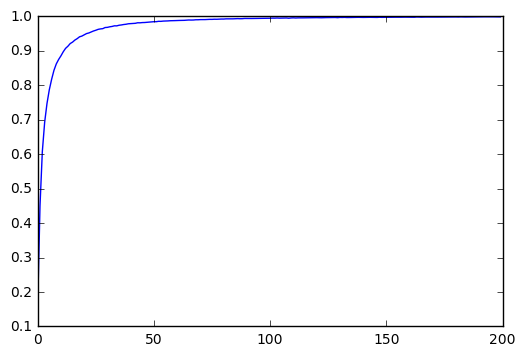

In [13]:
print('start plotting ...')

plt.plot(train_accuracy)

for index, v_acc in enumerate(accuracies):
    print('{0}: {1:.4f}'.format(index, v_acc))
print('Average')



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I use EPOCH = 200, since increasing the EPOCH no longer increases the traing accuracy. with batch size 256. I use Adam Optimizer since it's more sophisticated than SGD optimizer.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

1. LeNet5
    * First attemp (LeNet5): As a starting point, I tried LeNet5 with a little modification. I used sklearn train_test_split with 10% as my validate set and run it for 10 EPOCHS (a little bit like k-fold k=10). 
    * The result on the testing set was quite good(0.992) but not as well on the testing set (0.913), so I think it should be overfitting.
2. K-fold
3. Drop-out
    *
    *

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.